# Template Model Classification - Dataset X_train

In [1]:
#import semua library yg bakalan dipake di sini, biar rapih
#kalo kurang tambahin aja yaa wkwkwk

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, auc, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

# IMPORT & SPLIT DATASET 

In [2]:
df_train_x_train = pd.read_csv('processed_dataset/Train/processed_Train_X_train.csv')
df_test_x_train = pd.read_csv('processed_dataset/Test/processed_Test_X_train.csv')

In [3]:
df_train_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         10500 non-null  float64
 1   Customer_rating             10500 non-null  float64
 2   Cost_of_the_Product         10500 non-null  float64
 3   Prior_purchases             10500 non-null  float64
 4   Discount_offered            10500 non-null  float64
 5   Weight_in_gms               10500 non-null  float64
 6   Gender_encoded              10500 non-null  int64  
 7   Product_importance_encoded  10500 non-null  int64  
 8   Warehouse_block_A           10500 non-null  int64  
 9   Warehouse_block_B           10500 non-null  int64  
 10  Warehouse_block_C           10500 non-null  int64  
 11  Warehouse_block_D           10500 non-null  int64  
 12  Warehouse_block_F           10500 non-null  int64  
 13  Mode_of_Shipment_Flight     105

In [4]:
df_test_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         2200 non-null   float64
 1   Customer_rating             2200 non-null   float64
 2   Cost_of_the_Product         2200 non-null   float64
 3   Prior_purchases             2200 non-null   float64
 4   Discount_offered            2200 non-null   float64
 5   Weight_in_gms               2200 non-null   float64
 6   arrived_late                2200 non-null   int64  
 7   Gender_encoded              2200 non-null   int64  
 8   Product_importance_encoded  2200 non-null   int64  
 9   Warehouse_block_A           2200 non-null   int64  
 10  Warehouse_block_B           2200 non-null   int64  
 11  Warehouse_block_C           2200 non-null   int64  
 12  Warehouse_block_D           2200 non-null   int64  
 13  Warehouse_block_F           2200 

In [5]:
#split X dan Y 
#moga2 split train sama testnya bener ya KWKWKWKWK

X_train = df_train_x_train.drop('arrived_late', axis = 1)
y_train = df_train_x_train['arrived_late']
X_test = df_test_x_train.drop('arrived_late', axis = 1)
y_test = df_test_x_train['arrived_late']

# FUNCTIONS

In [6]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
#     print("AUC (test-label): %.2f" % roc_auc_score(y_test, y_pred))
#     print("AUC (train-label): %.2f" % roc_auc_score(y_train, y_pred_train))
    print('\n------------------------\n')
    print(classification_report(y_test, y_pred))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')
    
#feature importance untuk SVM
def feature_plot(classifier, feature_names, top_features=8):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 0 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
    plt.show()

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [7]:
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(C, train_scores, label='Train')
    plt.plot(C, test_scores, label='Test')
    plt.legend()
    plt.show()

# AdaBoost (Almas)

In [8]:
ada = AdaBoostClassifier()

In [9]:
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
eval_classification(ada)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.98
Recall (Test Set): 0.46
F1-Score (Test Set): 0.63
AUC (test-proba): 0.75
AUC (train-proba): 0.76

------------------------

              precision    recall  f1-score   support

           0       0.55      0.99      0.71       887
           1       0.98      0.46      0.63      1313

    accuracy                           0.67      2200
   macro avg       0.77      0.72      0.67      2200
weighted avg       0.81      0.67      0.66      2200



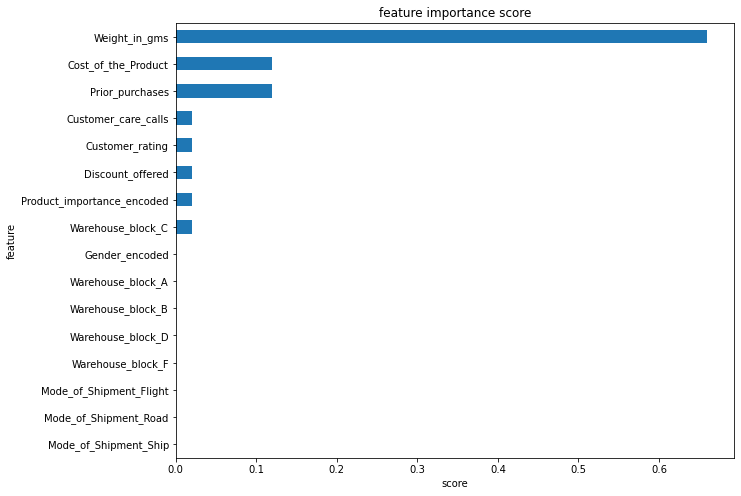

In [10]:
show_feature_importance(ada)

# Logistic Regression (Riyan) - Best Fit

In [11]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.84
Recall (Test Set): 0.52
F1-Score (Test Set): 0.64
AUC (test-proba): 0.72
AUC (train-proba): 0.72

------------------------

              precision    recall  f1-score   support

           0       0.54      0.85      0.66       887
           1       0.84      0.52      0.64      1313

    accuracy                           0.65      2200
   macro avg       0.69      0.68      0.65      2200
weighted avg       0.72      0.65      0.65      2200



In [12]:
show_feature_importance(model)
# gak bisa pake show_feature_importance, temen" ada opsi lain?

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# Decision Tree (Arsya)

In [13]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
eval_classification(dt)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.69
Recall (Test Set): 0.71
F1-Score (Test Set): 0.70
AUC (test-proba): 0.62
AUC (train-proba): 1.00

------------------------

              precision    recall  f1-score   support

           0       0.55      0.54      0.55       887
           1       0.69      0.71      0.70      1313

    accuracy                           0.64      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.64      0.64      0.64      2200



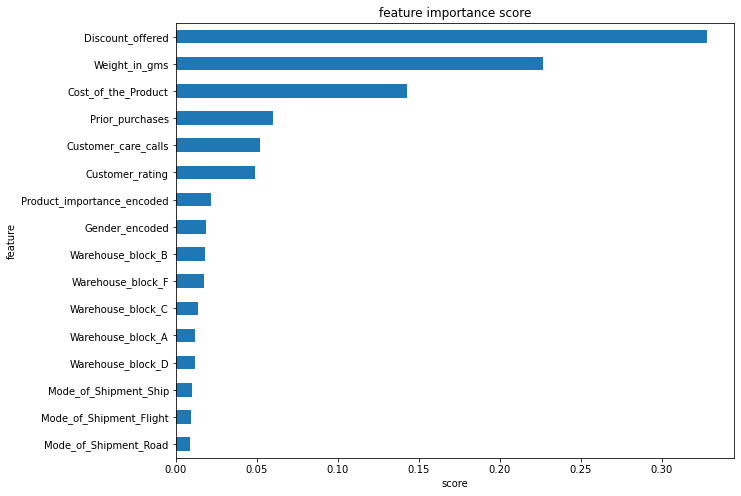

In [14]:
show_feature_importance(dt)

# Random Forest (Edo)

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
eval_classification(rf)

Accuracy (Test Set): 0.66
Precision (Test Set): 0.79
Recall (Test Set): 0.58
F1-Score (Test Set): 0.67
AUC (test-proba): 0.73
AUC (train-proba): 1.00

------------------------

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       887
           1       0.79      0.58      0.67      1313

    accuracy                           0.66      2200
   macro avg       0.67      0.68      0.66      2200
weighted avg       0.70      0.66      0.66      2200



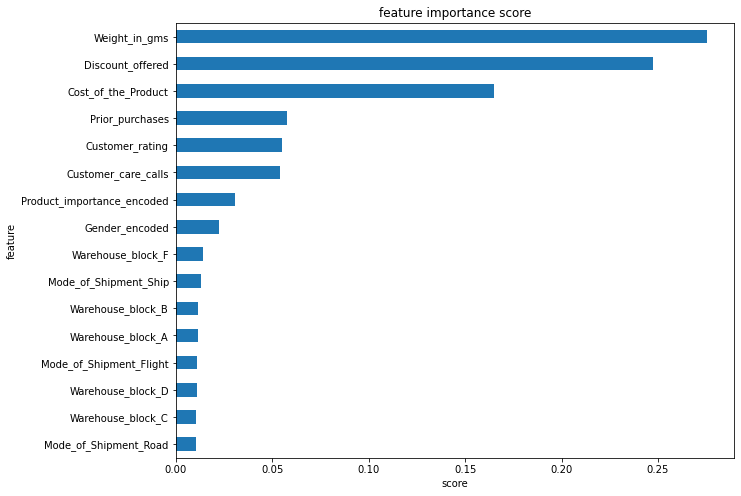

In [16]:
show_feature_importance(rf)

# Support Vector Classification (Afif) - Best Fit

In [17]:
svc = SVC(kernel='linear',probability=True)
svc.fit(X_train,y_train)


y_pred = svc.predict(X_test)
eval_classification(svc)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.99
Recall (Test Set): 0.40
F1-Score (Test Set): 0.57
AUC (test-proba): 0.72
AUC (train-proba): 0.72

------------------------

              precision    recall  f1-score   support

           0       0.53      0.99      0.69       887
           1       0.99      0.40      0.57      1313

    accuracy                           0.64      2200
   macro avg       0.76      0.70      0.63      2200
weighted avg       0.80      0.64      0.62      2200



Model dinilai telah mencapai best-fit, karena memiliki nilai AUC pada test & train yang tidak berbeda.

Pada pemilihan model, tim berfokus untuk mengurangi keselahan prediksi shipping yang sampai tepat waktu, padahal aktualnya telat (mengurangi false positive). Nilai tersebut bisa didapatkan dari precision pada nilai target '0' atau recall pada nilai target '1'. Dari nilai precision & recall, model ini telah memiliki nilai yang cukup baik.

In [18]:
features_names= X_train.columns.values
features_names

array(['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
       'Gender_encoded', 'Product_importance_encoded',
       'Warehouse_block_A', 'Warehouse_block_B', 'Warehouse_block_C',
       'Warehouse_block_D', 'Warehouse_block_F',
       'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road',
       'Mode_of_Shipment_Ship'], dtype=object)

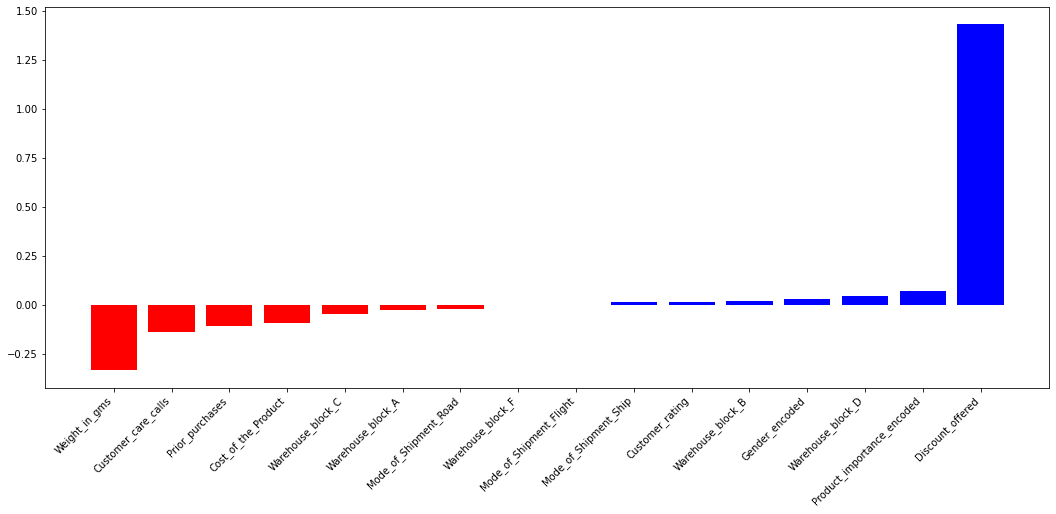

In [19]:
feature_plot(svc, features_names)

dalam model menggunakan algoritma SVC, features discount_offered memiliki koefisien positive paling bermakna terhadap target. 

# K-Nearest Neighbor (Ahdan)

In [20]:
knn = KNeighborsClassifier()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
eval_classification(knn)

Accuracy (Test Set): 0.63
Precision (Test Set): 0.75
Recall (Test Set): 0.58
F1-Score (Test Set): 0.65
AUC (test-proba): 0.70
AUC (train-proba): 0.89

------------------------

              precision    recall  f1-score   support

           0       0.53      0.71      0.61       887
           1       0.75      0.58      0.65      1313

    accuracy                           0.63      2200
   macro avg       0.64      0.64      0.63      2200
weighted avg       0.66      0.63      0.64      2200



# XGBoost (Agas)

In [21]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

eval_classification(xgb)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.82
Recall (Test Set): 0.57
F1-Score (Test Set): 0.67
AUC (test-proba): 0.74
AUC (train-proba): 0.98

------------------------

              precision    recall  f1-score   support

           0       0.56      0.81      0.66       887
           1       0.82      0.57      0.67      1313

    accuracy                           0.67      2200
   macro avg       0.69      0.69      0.67      2200
weighted avg       0.71      0.67      0.67      2200



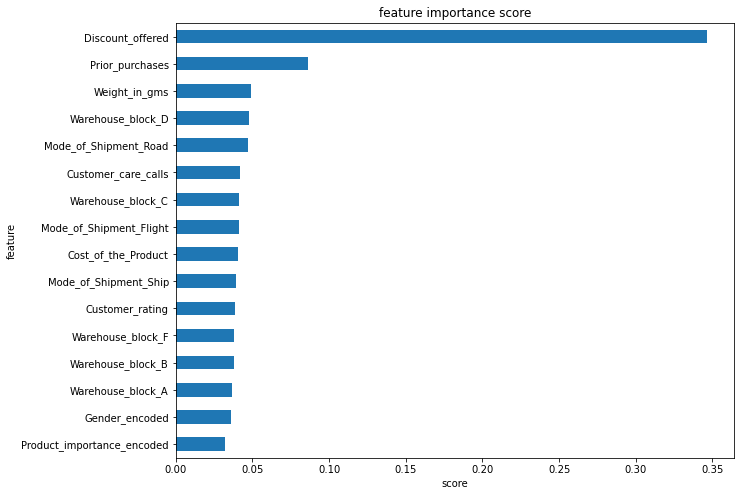

In [22]:
show_feature_importance(xgb)